# Przewidywanie pensji zawodników NBA na podstawie ich statystyk

## Pobieramy pensje zawodnikow za dany rok ze strony https://www.espn.com/nba/salaries/_/year i zapisujemy je w plikach

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

def get_players_salary_from_season(year):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    url = f"https://www.espn.com/nba/salaries/_/year/{year}/page/1/seasontype/3"
    response = requests.get(url, headers=headers)
    response.raise_for_status() 
    soup = BeautifulSoup(response.content, 'html.parser')

    page_numbers_div = soup.find('div', class_='page-numbers').text
    pages_number = int(page_numbers_div.split()[-1])

    all_data = [] 

    for i in range(1, pages_number + 1):
        print(f"Salaries dla {year}, strona {i} z {pages_number}")
        url = f"https://www.espn.com/nba/salaries/_/year/{year}/page/{i}/seasontype/3"
        response = requests.get(url, headers=headers)
        response.raise_for_status()  
        soup = BeautifulSoup(response.content, 'html.parser')

        table = soup.find('table', class_='tablehead')

        if table:
            data = []
            rows = table.find_all('tr')
            header_row = rows[0].find_all('td')
            header = [cell.text.strip() for cell in header_row]
            for row in rows[1:]:
                cells = row.find_all('td')
                name = cells[1].text.strip().split(',')[0]  
                team = cells[2].text.strip()
                salary = cells[3].text.strip() 
                if name != "NAME" and team != "TEAM" and salary != "SALARY":
                    data.append([name, team, salary])

            all_data.extend(data)
        else:
            print("Table with class 'tablehead' not found.")
    
    df = pd.DataFrame(all_data, columns=['Name', 'Team', 'Salary'])
    
    filename = f"nba_salaries_{year}.csv"
    df.to_csv(index=False, path_or_buf=f"data/salaries/{filename}")
    print(f"Data saved to {filename}")


for i in range(2000, 2024):
    file = f"data/salaries/nba_salaries_{i}.csv"
    if not os.path.exists(file):
        get_players_salary_from_season(i)

file = "data/salaries/nba_salaries_2020.csv"
print(pd.read_csv(file).head())


                Name                   Team       Salary
0      Stephen Curry  Golden State Warriors  $40,231,758
1  Russell Westbrook        Houston Rockets  $38,506,482
2         Chris Paul  Oklahoma City Thunder  $38,506,482
3       Kevin Durant           Phoenix Suns  $38,199,000
4       James Harden        Houston Rockets  $38,199,000


<br><br><br>
# z NBA API pobieramy statystyki danego gracza i łączymy je z wczesniejszymi pensjami

In [3]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats

def create_season_stats(year):
    csv_salary_file_path = f'data/salaries/nba_salaries_{year}.csv'
    season = f"{year-1}-{str(year)[2:]}"
    salary_df = pd.read_csv(csv_salary_file_path)

    salary_df = salary_df.drop_duplicates(subset=['Name'])

    player_names = salary_df['Name']

    season_stats = []

    for player_name in player_names:
        print(f"Sezon: {season}, procent wykonania: {player_names.tolist().index(player_name) / len(player_names) * 100:.2f}%", end="\r")
        
        # Znalezienie gracza w bazie NBA
        player_info = players.find_players_by_full_name(player_name)
        
        if player_info:
            player_id = player_info[0]['id']

            career = playercareerstats.PlayerCareerStats(player_id=player_id)
            career_df = career.get_data_frames()[0]

            # Filtrowanie statystyk dla konkretnego sezonu
            player_season_stats = career_df[career_df['SEASON_ID'] == season].copy()
            # Dodanie nazwy gracza i wynagrodzenia do danych statystyk
            player_season_stats['Name'] = player_name
            player_season_stats['Salary'] = salary_df[salary_df['Name'] == player_name]['Salary'].values[0]

            season_stats.append(player_season_stats)
        else:
            print(f"Player {player_name} not found in NBA database")


    season_stats_df = pd.concat(season_stats)
    season_stats_df.columns = season_stats_df.columns.str.strip()
    season_stats_df = season_stats_df.drop_duplicates(subset=['PLAYER_ID'], keep=False)

    file_name = f'season_stats_{year}.csv'
    season_stats_df.to_csv(index=False, path_or_buf=f"data/stats_and_salaries/{file_name}")
    print(f"Data saved to {file_name}")

for i in range(2000, 2024):
    file = f"data/stats_and_salaries/season_stats_{i}.csv"
    if not os.path.exists(file):
        create_season_stats(i)

file = "data/stats_and_salaries/season_stats_2020.csv"
print(pd.read_csv(file).head())

   PLAYER_ID SEASON_ID  LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  \
0     201939   2019-20          0  1610612744               GSW        32.0   
1     201566   2019-20          0  1610612745               HOU        31.0   
2     101108   2019-20          0  1610612760               OKC        35.0   
3     201935   2019-20          0  1610612745               HOU        30.0   
4       2544   2019-20          0  1610612747               LAL        35.0   

   GP  GS     MIN  FGM  ...  DREB  REB  AST  STL  BLK  TOV   PF   PTS  \
0   5   5   139.0   33  ...    22   26   33    5    2   16   11   104   
1  57  57  2049.0  604  ...   351  451  401   93   20  255  200  1553   
2  70  70  2208.0  434  ...   323  349  472  111   11  161  158  1232   
3  68  68  2483.0  672  ...   376  446  512  125   60  308  227  2335   
4  67  67  2316.0  643  ...   459  525  684   78   36  261  118  1698   

                Name       Salary  
0      Stephen Curry  $40,231,758  
1  Russell Wes

<br><br><br>
# Pobieramy równie z NBA API dane gracza jak wzrost, numer draftu czy waga i doswiadczenie

In [4]:
from nba_api.stats.endpoints import CommonPlayerInfo

def get_common_player_info(year):
    season = f"{year-1}-{str(year)[2:]}"
    stats_file = f'data/stats_and_salaries/season_stats_{year}.csv'
    stats_df = pd.read_csv(stats_file)

    stats_df.columns = stats_df.columns.str.strip()

    player_ids = stats_df["PLAYER_ID"]

    all_players_info_list = [] 

    for player_id in player_ids:
        print(f"Sezon: {season}, procent wykonania: {player_ids.tolist().index(player_id) / len(player_ids) * 100:.2f}%", end="\r")

        player_info = CommonPlayerInfo(player_id=player_id)
        player_info = player_info.get_data_frames()[0]
   
        all_players_info_list.append(player_info)

    all_players_info = pd.concat(all_players_info_list, ignore_index=True)

    folder_name = "data/common_player_infos"
    os.makedirs(folder_name, exist_ok=True)

    output_file = os.path.join(folder_name, f"common_info_players_{year}.csv")
    all_players_info.to_csv(output_file, index=False)
    print("Dane zostały zapisane do pliku:", output_file)

for year in range(2000, 2024):
    file = f"data/common_player_infos/common_info_players_{year}.csv"
    if not os.path.exists(file):
        get_common_player_info(year)
    
file = "data/common_player_infos/common_info_players_2020.csv"
print(pd.read_csv(file).head())


   PERSON_ID FIRST_NAME  LAST_NAME DISPLAY_FIRST_LAST  \
0     201939    Stephen      Curry      Stephen Curry   
1     201566    Russell  Westbrook  Russell Westbrook   
2     101108      Chris       Paul         Chris Paul   
3     201935      James     Harden       James Harden   
4       2544     LeBron      James       LeBron James   

  DISPLAY_LAST_COMMA_FIRST DISPLAY_FI_LAST        PLAYER_SLUG  \
0           Curry, Stephen        S. Curry      stephen-curry   
1       Westbrook, Russell    R. Westbrook  russell-westbrook   
2              Paul, Chris         C. Paul         chris-paul   
3            Harden, James       J. Harden       james-harden   
4            James, LeBron        L. James       lebron-james   

             BIRTHDATE                        SCHOOL COUNTRY  ...  \
0  1988-03-14T00:00:00                      Davidson     USA  ...   
1  1988-11-12T00:00:00                          UCLA     USA  ...   
2  1985-05-06T00:00:00                   Wake Forest     US

<br><br><br>
# Łączymy wczesniejsze dane i pensje graczy z informacjami o graczach i czyścimi dane tzn usuwamy niepotrzebne i modyfikujemy

In [5]:
def get_final_stats(year):

    df1 = pd.read_csv(f'data/common_player_infos/common_info_players_{year}.csv')
    df2 = pd.read_csv(f'data/stats_and_salaries/season_stats_{year}.csv')

    together = pd.merge(df1, df2, left_on='PERSON_ID', right_on='PLAYER_ID', how='inner')
    together.columns = together.columns.str.strip()
    together = together.dropna()

    together = together.drop(['PERSON_ID', 'FIRST_NAME', 'LAST_NAME', 'DISPLAY_FIRST_LAST', 'DISPLAY_LAST_COMMA_FIRST', 'DISPLAY_FI_LAST', 'PLAYER_SLUG', 'SCHOOL', 'COUNTRY', 'LAST_AFFILIATION', 'SEASON_EXP', 'JERSEY', 'TEAM_ID_x', 'ROSTERSTATUS', 'GAMES_PLAYED_CURRENT_SEASON_FLAG', 'TEAM_NAME', 'TEAM_NAME', 'TEAM_CITY', 'PLAYERCODE', 'TO_YEAR', 'DLEAGUE_FLAG', 'NBA_FLAG', 'GAMES_PLAYED_FLAG', 'DRAFT_YEAR', 'DRAFT_ROUND', 'GREATEST_75_FLAG', 'TEAM_ABBREVIATION_x', 'TEAM_CODE', 'LEAGUE_ID', 'TEAM_ID_y', 'BIRTHDATE', 'FG_PCT', 'FG3_PCT', 'FT_PCT'], axis=1)
    together = together.drop(['FGM','FGA','FG3M','FG3A','FTM','FTA'], axis=1)
    together = together.drop(['OREB', 'DREB', 'PF'], axis=1)


    together.insert(0, 'Name', together.pop('Name'))
    together.insert(0, 'PLAYER_ID', together.pop('PLAYER_ID'))

    together['Salary'] = together['Salary'].str.replace(',', '').str.replace('$', '').astype(float)
    together['Salary'] = round(together['Salary'] / 1000000, 2)
    together = together[together['Salary'] != 0]

    together['POSITION'] = together['POSITION'].replace('Guard-Forward', 'Forward-Guard')
    together['POSITION'] = together['POSITION'].replace('Center-Forward', 'Forward-Center')
    
    def convert_height_to_cm(height):
        if '-' in height:
            feet, inches = height.split('-')
            return round(int(feet) * 30.48 + int(inches) * 2.54,2)
        else:
            return round(float(height),2)
        
    together['HEIGHT'] = together['HEIGHT'].apply(convert_height_to_cm)

    # Zmiana wartości w kolumnie 'From year' na liczbę lat doświadczenia
    together['FROM_YEAR'] = together['SEASON_ID'].str[:4].astype(int) - together['FROM_YEAR'].astype(int)
    together = together.rename(columns={'FROM_YEAR': 'SEASON_EXP'})
    together = together.drop(['PLAYER_AGE'], axis=1)


    # Zmiana wartości w kolumnie 'DRAFT_NUMBER' z 'Undrafted' na 61
    together['DRAFT_NUMBER'] = together['DRAFT_NUMBER'].replace('Undrafted', 61)
    together.loc[together['DRAFT_NUMBER'].astype(int) > 60, 'DRAFT_NUMBER'] = 61


    # zmiana statystyk z całego sezonu na statystyki na mecz
    together['MIN'] = round(together['MIN'] / together['GP'],2)
    together['PTS'] = round(together['PTS'] / together['GP'],2)
    together['REB'] = round(together['REB'] / together['GP'],2)
    together['AST'] = round(together['AST'] / together['GP'],2)
    together['STL'] = round(together['STL'] / together['GP'],2)
    together['BLK'] = round(together['BLK'] / together['GP'],2)
    together['TOV'] = round(together['TOV'] / together['GP'],2)
    together['GS'] = round(together['GS'] / together['GP'],2)


    together = together.rename(columns={'MIN': 'MIN/G', 'PTS': 'PTS/G', 'REB': 'REB/G', 'AST': 'AST/G', 'STL': 'STL/G', 'BLK': 'BLK/G', 'TOV': 'TOV/G', 'GS': 'GS/G'})

    
    together.columns = together.columns.str.strip()
    together.to_csv(f'data/final_stats/final_stats_{year}.csv', index=False)
    print(f"Data saved to final_stats_{year}.csv")



for year in range(2000, 2024):
    file = f"data/final_stats/final_stats_{year}.csv"
    if os.path.exists(file):
        get_final_stats(year)

file = "data/final_stats/final_stats_2020.csv"
print(pd.read_csv(file).head())

Data saved to final_stats_2000.csv
Data saved to final_stats_2001.csv
Data saved to final_stats_2002.csv
Data saved to final_stats_2003.csv
Data saved to final_stats_2004.csv
Data saved to final_stats_2005.csv
Data saved to final_stats_2006.csv
Data saved to final_stats_2007.csv
Data saved to final_stats_2008.csv
Data saved to final_stats_2009.csv
Data saved to final_stats_2010.csv
Data saved to final_stats_2011.csv
Data saved to final_stats_2012.csv
Data saved to final_stats_2013.csv
Data saved to final_stats_2014.csv
Data saved to final_stats_2015.csv
Data saved to final_stats_2016.csv
Data saved to final_stats_2017.csv
Data saved to final_stats_2018.csv
Data saved to final_stats_2019.csv
Data saved to final_stats_2020.csv
Data saved to final_stats_2021.csv
Data saved to final_stats_2022.csv
Data saved to final_stats_2023.csv
   PLAYER_ID               Name  HEIGHT  WEIGHT POSITION  SEASON_EXP  \
0     201939      Stephen Curry  187.96     185    Guard          10   
1     201566  Ru

<br><br><br>
# Tworzymy tez jeden plik w ktorym sa wszystkie dane z wszystkich sezonow

In [6]:
def merge_final_stats():
    all_final_stats = []
    for year in range(2000, 2024):
        df = pd.read_csv(f'data/final_stats/final_stats_{year}.csv')
        all_final_stats.append(df)
    all_final_stats = pd.concat(all_final_stats, ignore_index=True)
    all_final_stats.to_csv('data/final_stats/all_final_stats.csv', index=False)

merge_final_stats()

<br><br><br>
# Tworzymy pliki z danymi dla osobnych pozycji

In [7]:
def filter_data_by_position(data, position):
    filtered_data = data[data['POSITION'] == position]
    return filtered_data


data = pd.read_csv('data/final_stats/all_final_stats.csv')
Center_Data = filter_data_by_position(data, 'Center')
Forward_Data = filter_data_by_position(data, 'Forward')
Guard_Data = filter_data_by_position(data, 'Guard')

Center_Data.to_csv('data/final_stats/Center_Data.csv', index=False)
Forward_Data.to_csv('data/final_stats/Forward_Data.csv', index=False)
Guard_Data.to_csv('data/final_stats/Guard_Data.csv', index=False)

<br><br><br>
# Tutaj tworzymy wykresy i dane dotyczace pensji

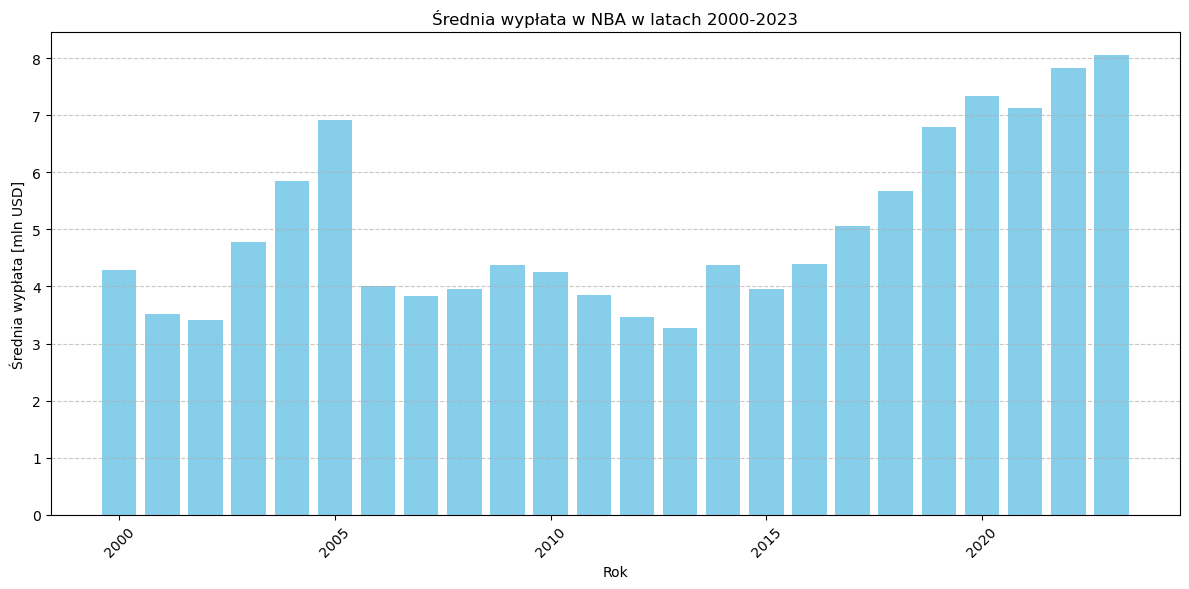

In [8]:
import matplotlib.pyplot as plt


def plot_mean_salary_by_year():
    mean_salaries = {}
    for year in range(2000, 2024):
        file = f"data/salaries/nba_salaries_{year}.csv"
        df = pd.read_csv(file)
        df['Salary'] = df['Salary'].str.replace(',', '').str.replace('$', '').astype(float)
        mean_salary = df['Salary'].mean()
        mean_salary = round(mean_salary / 1000000, 2)
        mean_salaries[year] = mean_salary

    plt.figure(figsize=(12, 6))
    plt.bar(mean_salaries.keys(), mean_salaries.values(), color='skyblue')
    plt.title("Średnia wypłata w NBA w latach 2000-2023")
    plt.xlabel("Rok")
    plt.ylabel("Średnia wypłata [mln USD]")
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_mean_salary_by_year()

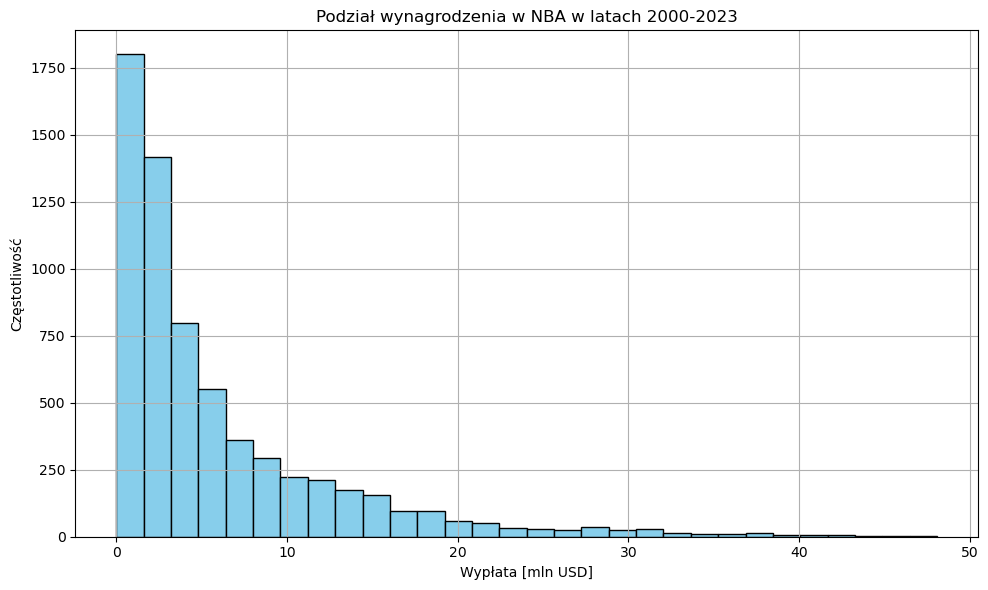

In [9]:
def salary_distribution_plot(data):
    plt.figure(figsize=(10, 6))
    plt.hist(data['Salary'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Wypłata [mln USD]')
    plt.ylabel('Częstotliwość')
    plt.title('Podział wynagrodzenia w NBA w latach 2000-2023')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

data = pd.read_csv('data/final_stats/all_final_stats.csv')
salary_distribution_plot(data)

    

In [10]:

def salary_stats(data):
    salary = data['Salary']
    print(f"Minimum: {salary.min()}")
    print(f"Maksimum: {salary.max()}")
    print(f"Średnia: {round(salary.mean(), 2)}")
    print(f"Odchylenie standardowe: {round(salary.std(), 2)}")
    print(f"Mediana: {salary.median()}")
    print(f"Liczba obserwacji: {salary.count()}")

data = pd.read_csv('data/final_stats/all_final_stats.csv')
salary_stats(data)

Minimum: 0.01
Maksimum: 48.07
Średnia: 5.99
Odchylenie standardowe: 6.92
Mediana: 3.28
Liczba obserwacji: 6535


<br><br><br>
# Tworzymy macierz korelacji

Text(0.5, 1.0, 'Correlation Matrix')

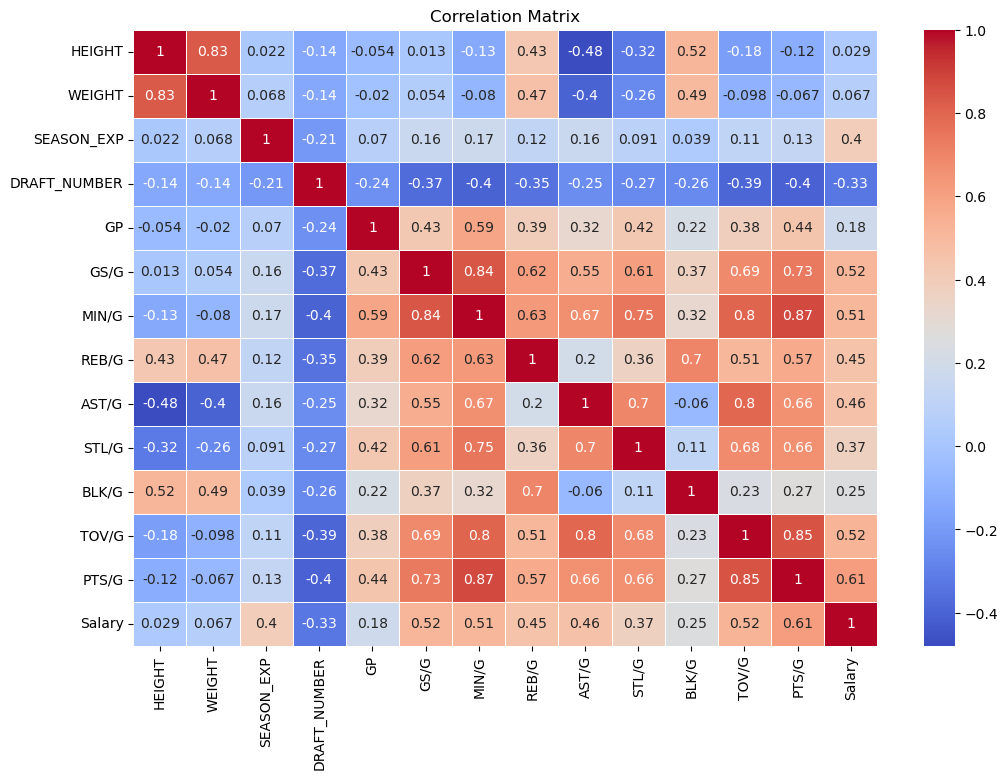

In [11]:
import seaborn as sns

data = pd.read_csv('data/final_stats/all_final_stats.csv')
data = data.drop(['PLAYER_ID', 'Name', 'POSITION', 'SEASON_ID', 'TEAM_ABBREVIATION_y'], axis=1)

coorelation_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(coorelation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')

<br><br><br>
# Tutaj testujemy modele i  wybieramy najlepszy

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt



data = pd.read_csv("data/final_stats/all_final_stats.csv")

X = data.drop(['Salary', 'PLAYER_ID', 'Name', 'SEASON_ID', 'POSITION', 'TEAM_ABBREVIATION_y'], axis=1)
y = data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

svm_rmse = root_mean_squared_error(y_test, svm_predictions)
rf_rmse = root_mean_squared_error(y_test, rf_predictions)
gb_rmse = root_mean_squared_error(y_test, gb_predictions)

svm_r2 = r2_score(y_test, svm_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
gb_r2 = r2_score(y_test, gb_predictions)


print("Wyniki oceny modeli:")
print("SVM RMSE:", svm_rmse)
print("SVM R2 Score:", svm_r2)
print("RandomForest RMSE:", rf_rmse)
print("RandomForest R2 Score:", rf_r2)
print("GradientBoosting RMSE:", gb_rmse)
print("GradientBoosting R2 Score:", gb_r2)





Wyniki oceny modeli:
SVM RMSE: 4.566427578164351
SVM R2 Score: 0.5015897007215822
RandomForest RMSE: 3.439730075001182
RandomForest R2 Score: 0.7171979281719578
GradientBoosting RMSE: 3.493295432119477
GradientBoosting R2 Score: 0.7083214505563189


<br><br><br>
# Tworzymy wykresy dla tych 3 modeli by pokazac jak przewiduja

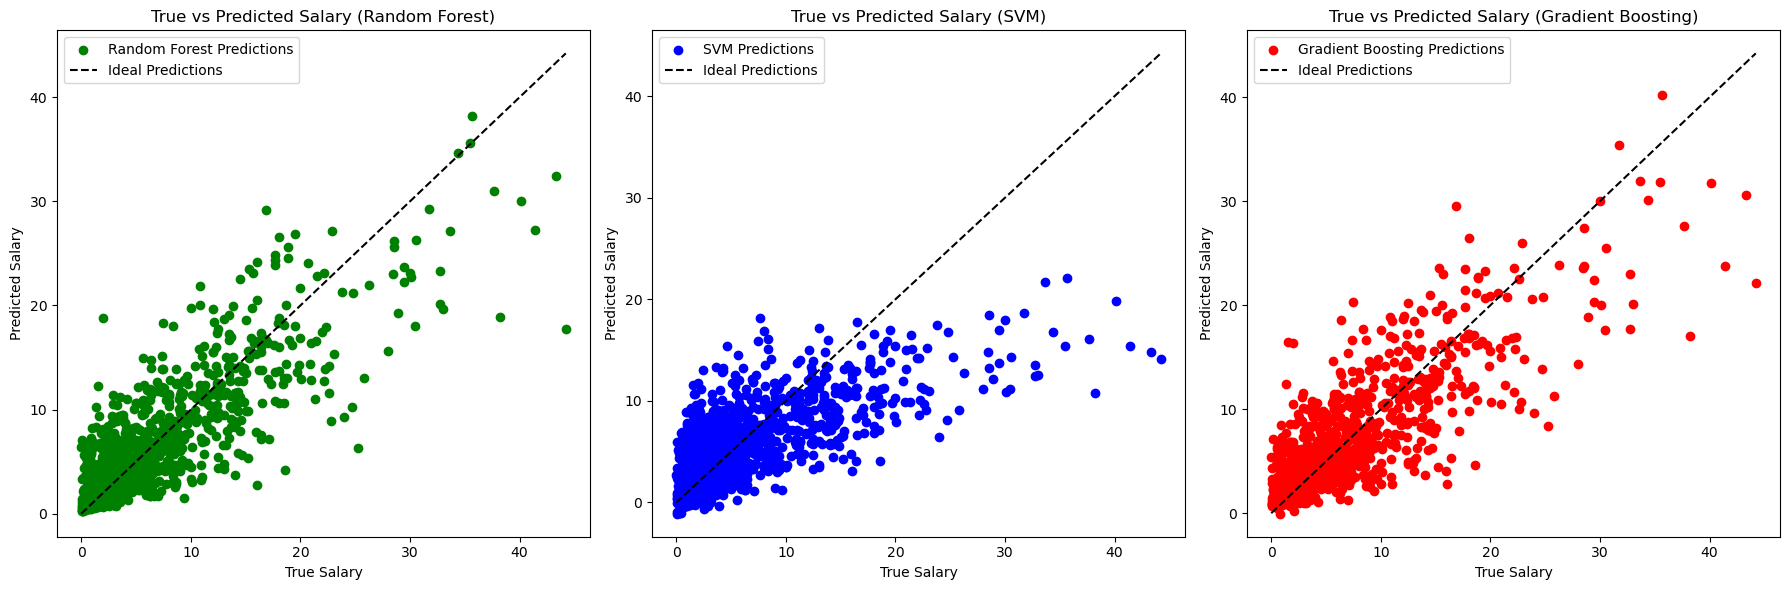

In [13]:
import matplotlib.pyplot as plt

def scatter_models_plot(ax, y_test, predictions_test, color='blue', model_name=''):
    ax.scatter(y_test, predictions_test, color=color, label=f'{model_name} Predictions')


    max_salary = max(y_test.max(), predictions_test.max())
    ax.plot([0, max_salary], [0, max_salary], color='black', linestyle='--', label='Ideal Predictions')


    ax.set_xlabel('True Salary')
    ax.set_ylabel('Predicted Salary')
    ax.set_title(f'True vs Predicted Salary ({model_name})')
    ax.legend()


models = [('Random Forest', rf_predictions, 'green'), ('SVM', svm_predictions, 'blue'), ('Gradient Boosting', gb_predictions, 'red')]

# Utworzenie jednej figury i trzech osi (wykresów) obok siebie
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Wykresy dla każdego modelu
for i, (model_name, predictions, color) in enumerate(models):
    scatter_models_plot(axes[i], y_test, predictions, color=color, model_name=model_name)

plt.tight_layout()
plt.show()


<br><br><br>
# Tworzymy plik gdzie zapisujemy wyniki naszego modelu

In [14]:


results_test_df = pd.DataFrame({
    'Name': data.iloc[X_test.index]['Name'].values,
    'Season': data.iloc[X_test.index]['SEASON_ID'].values,
    'Salary': y_test.values,
    'Salary predicted by RF': rf_predictions,
    'Difference RF': y_test.values - rf_predictions,
})

results_test_df = results_test_df.round(2)
results_test_df = results_test_df.sort_values(by='Difference RF', ascending=False)




results_test_df.to_csv('data/help/results_test.csv', index=False)
print(results_test_df.head())



                   Name   Season  Salary  Salary predicted by RF  \
236   Russell Westbrook  2021-22   44.21                   17.76   
1021        Rudy Gobert  2022-23   38.17                   18.87   
94          Joel Embiid  2017-18   25.25                    6.29   
29        Nicolas Batum  2018-19   24.00                    9.30   
800         Evan Turner  2019-20   18.61                    4.18   

      Difference RF  
236           26.45  
1021          19.30  
94            18.96  
29            14.70  
800           14.43  


<br><br><br>
# Tworzymy wykres by pokazac istotnosc cech dla modelu RF

/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/2312929824.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=pallete)


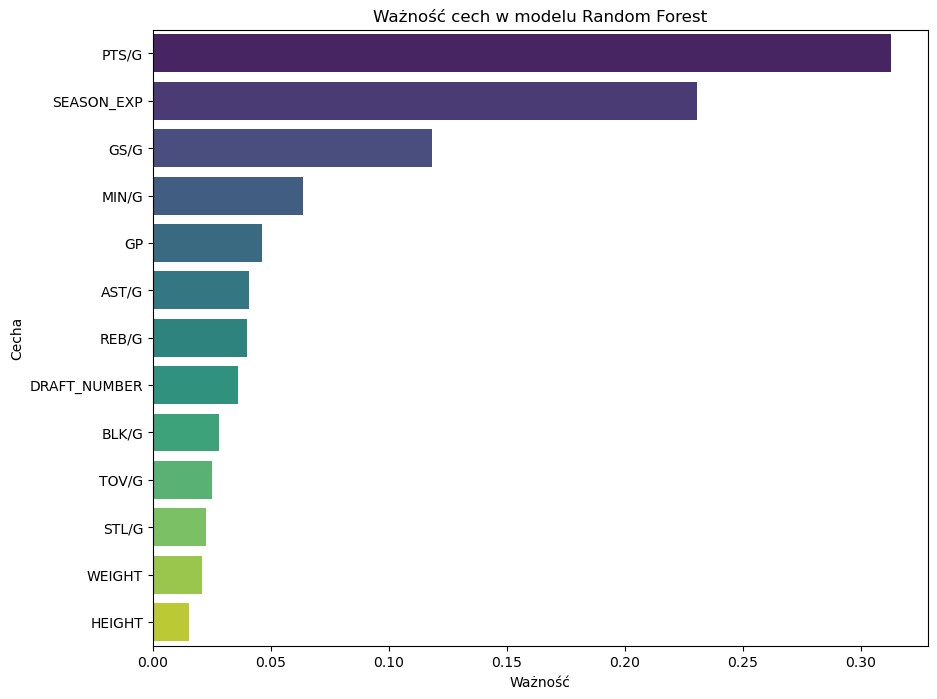

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importance(model, X, pallete='viridis'):

    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=pallete)
    plt.title('Ważność cech w modelu Random Forest')
    plt.xlabel('Ważność')
    plt.ylabel('Cecha')
    plt.show()

scatter_models_plot(axes[0], y_test, rf_predictions, color='green', model_name='Random Forest')
plot_feature_importance(rf_model, X)


<br><br><br>
# Tutaj tworzymy ograniczone dane by "ulepszyc" dane dla naszego modelu i robimy dla tego wykresy

Minimum: 0.51
Maksimum: 9.94
Średnia: 3.36
Odchylenie standardowe: 2.41
Mediana: 2.64
Liczba obserwacji: 4906
RandomForest RMSE: 1.6623556734804827
RandomForest R2 Score: 0.5032157297596902


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/2312929824.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=pallete)


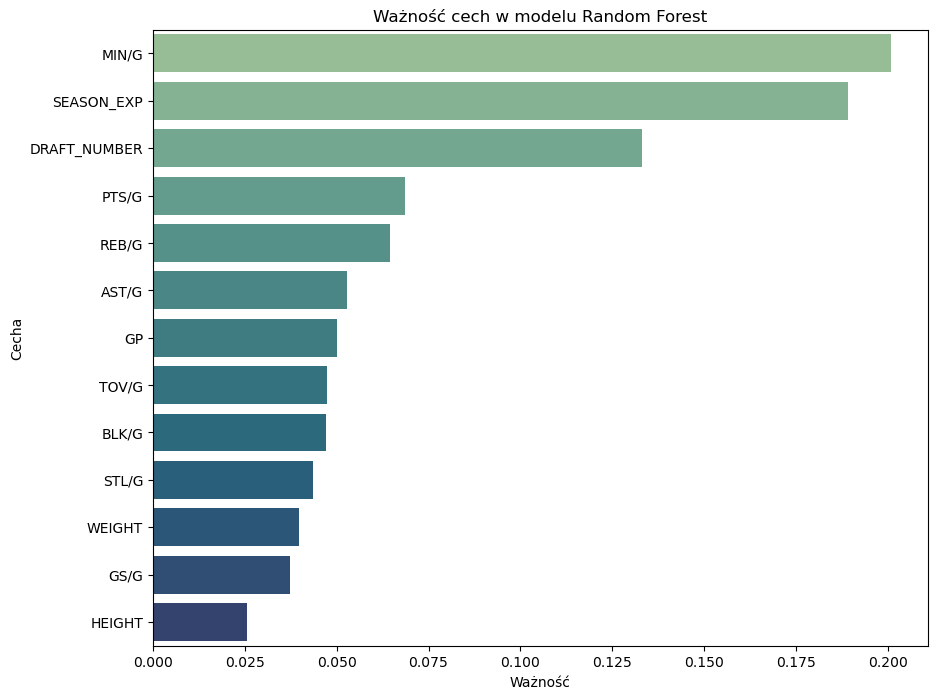

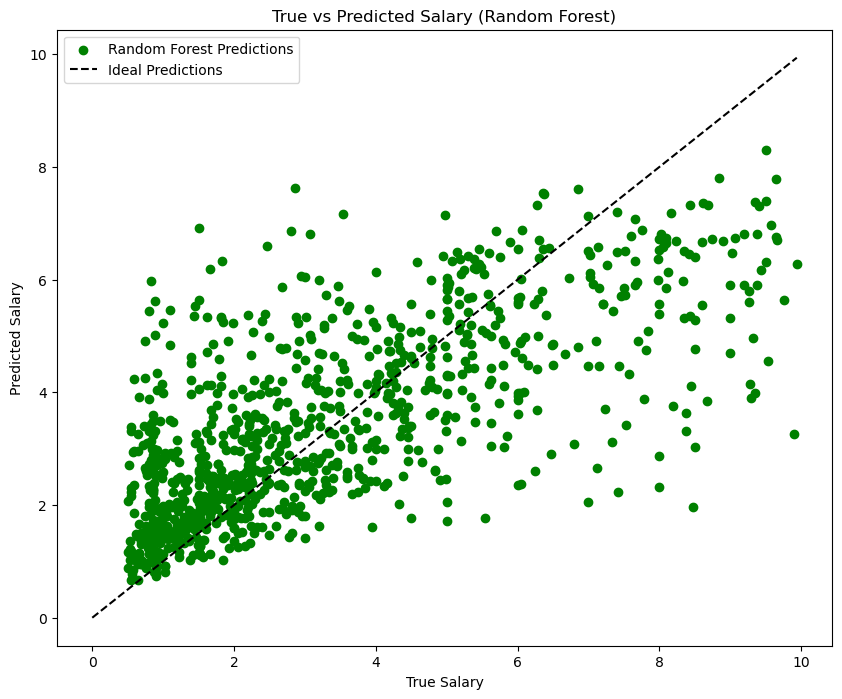

In [16]:
data = pd.read_csv('data/final_stats/all_final_stats.csv')

# Usuniecie zawodnikow co zarabiaja mniej niz 0.5 mln i wiecej niz 10 mln
data = data[(data['Salary'] > 0.5) & (data['Salary'] < 10)]

salary_stats(data)

data.to_csv('data/final_stats/all_final_stats_filtered.csv', index=False)

X = data.drop(['Salary', 'PLAYER_ID', 'Name', 'SEASON_ID', 'POSITION', 'TEAM_ABBREVIATION_y'], axis=1)
y = data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_rmse = root_mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("RandomForest RMSE:", rf_rmse)
print("RandomForest R2 Score:", rf_r2)

plot_feature_importance(rf_model, X, pallete='crest')

#scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter_models_plot(ax, y_test, rf_predictions, color='green', model_name='Random Forest')



<br><br><br>
# Tutaj tworzymy dane i statystyki dla poszczegolnych pozycji

Guard RandomForest RMSE: 3.611371058707443
Guard RandomForest R2 Score: 0.7383907339794684
Forward RandomForest RMSE: 3.520945426981596
Forward RandomForest R2 Score: 0.7303802799082013
Center RandomForest RMSE: 4.076073830721313
Center RandomForest R2 Score: 0.5619466548293929


 Feature importance dla poszczególnych pozycji:
Guard:


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/2312929824.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=pallete)


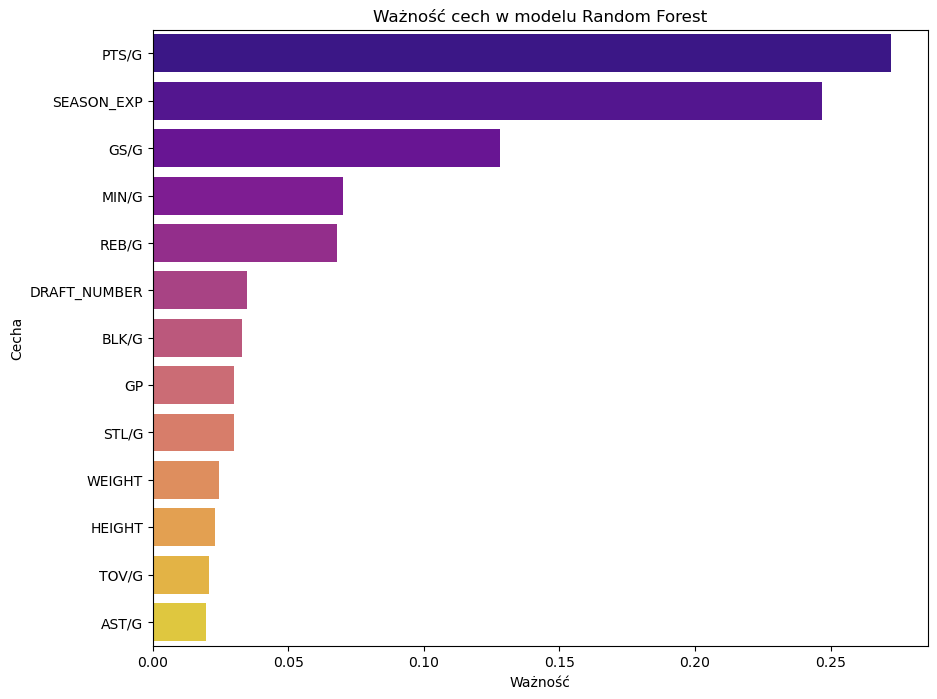

Forward:


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/2312929824.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=pallete)


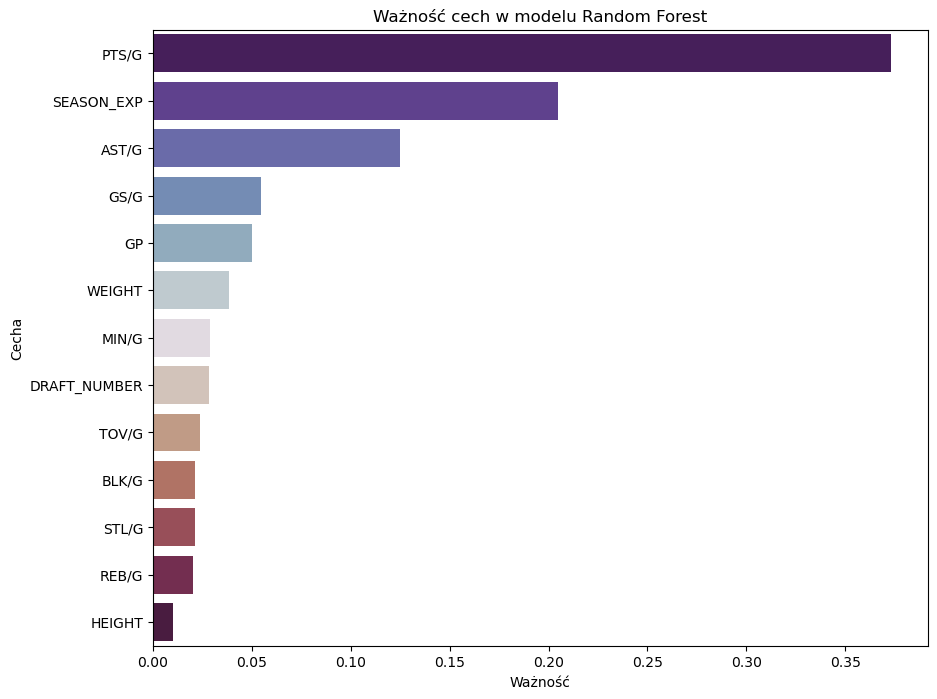

Center:


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/2312929824.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=pallete)


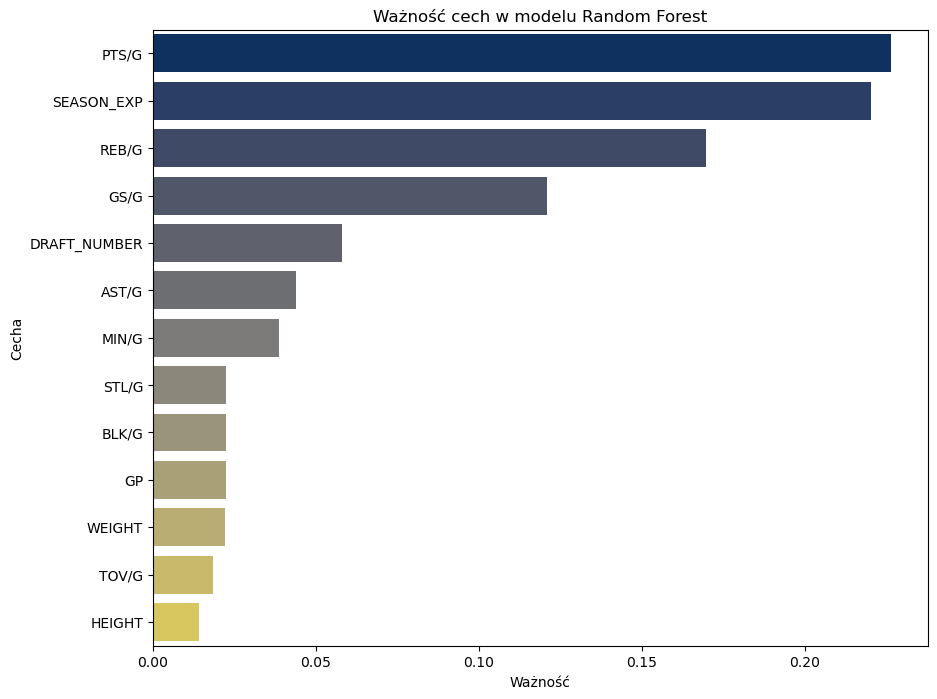

In [17]:
guard_data = pd.read_csv('data/final_stats/Guard_Data.csv')
forward_data = pd.read_csv('data/final_stats/Forward_Data.csv')
center_data = pd.read_csv('data/final_stats/Center_Data.csv')

guard_data_X = guard_data.drop(['Salary', 'PLAYER_ID', 'Name', 'SEASON_ID', 'POSITION', 'TEAM_ABBREVIATION_y'], axis=1)
guard_data_y = guard_data['Salary']

forward_data_X = forward_data.drop(['Salary', 'PLAYER_ID', 'Name', 'SEASON_ID', 'POSITION', 'TEAM_ABBREVIATION_y'], axis=1)
forward_data_y = forward_data['Salary']

center_data_X = center_data.drop(['Salary', 'PLAYER_ID', 'Name', 'SEASON_ID', 'POSITION', 'TEAM_ABBREVIATION_y'], axis=1)
center_data_y = center_data['Salary']

GX_train, GX_test, Gy_train, Gy_test = train_test_split(guard_data_X, guard_data_y, test_size=0.2, random_state=42)
FX_train, FX_test, Fy_train, Fy_test = train_test_split(forward_data_X, forward_data_y, test_size=0.2, random_state=42)
CX_train, CX_test, Cy_train, Cy_test = train_test_split(center_data_X, center_data_y, test_size=0.2, random_state=42)

guard_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
guard_rf_model.fit(GX_train, Gy_train)

forward_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
forward_rf_model.fit(FX_train, Fy_train)

center_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
center_rf_model.fit(CX_train, Cy_train)

guard_rf_predictions = guard_rf_model.predict(GX_test)
forward_rf_predictions = forward_rf_model.predict(FX_test)
center_rf_predictions = center_rf_model.predict(CX_test)

guard_rf_rmse = root_mean_squared_error(Gy_test, guard_rf_predictions)
guard_rf_r2 = r2_score(Gy_test, guard_rf_predictions)

forward_rf_rmse = root_mean_squared_error(Fy_test, forward_rf_predictions)
forward_rf_r2 = r2_score(Fy_test, forward_rf_predictions)

center_rf_rmse = root_mean_squared_error(Cy_test, center_rf_predictions)
center_rf_r2 = r2_score(Cy_test, center_rf_predictions)

print("Guard RandomForest RMSE:", guard_rf_rmse)
print("Guard RandomForest R2 Score:", guard_rf_r2)

print("Forward RandomForest RMSE:", forward_rf_rmse)
print("Forward RandomForest R2 Score:", forward_rf_r2)

print("Center RandomForest RMSE:", center_rf_rmse)
print("Center RandomForest R2 Score:", center_rf_r2)


print('\n\n Feature importance dla poszczególnych pozycji:')
print('Guard:')
guard_feature_importance = guard_rf_model.feature_importances_
plot_feature_importance(guard_rf_model, guard_data_X, pallete='plasma')


print('Forward:')
forward_feature_importance = forward_rf_model.feature_importances_
plot_feature_importance(forward_rf_model, forward_data_X, pallete='twilight_shifted')

print('Center:')
center_feature_importance = center_rf_model.feature_importances_
plot_feature_importance(center_rf_model, center_data_X, pallete='cividis')



<br><br>

## Wykresy do pozniejszego wykorzystania

/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/2295953593.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='POSITION', y='Salary', palette='viridis')


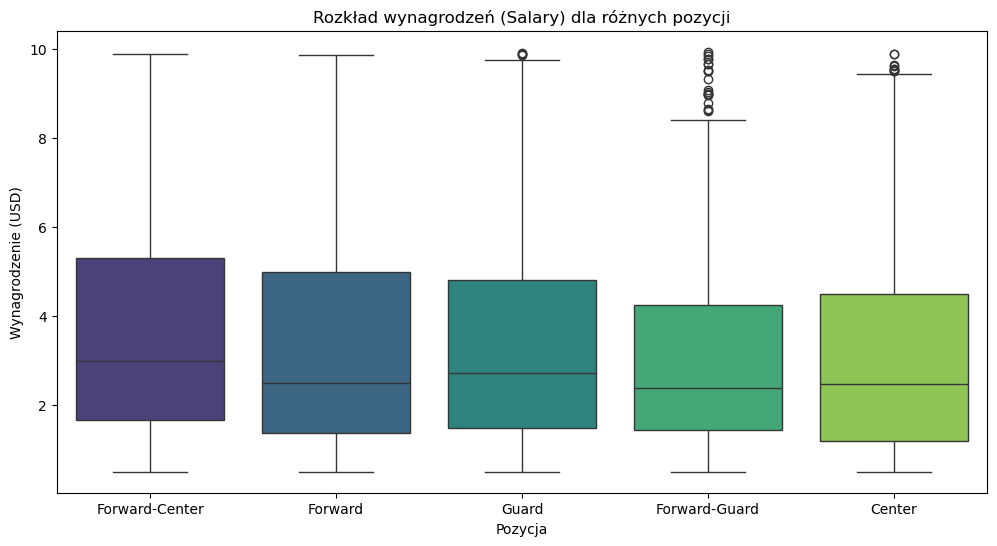

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='POSITION', y='Salary', palette='viridis')
plt.title('Rozkład wynagrodzeń (Salary) dla różnych pozycji')
plt.xlabel('Pozycja')
plt.ylabel('Wynagrodzenie (USD)')
plt.show()


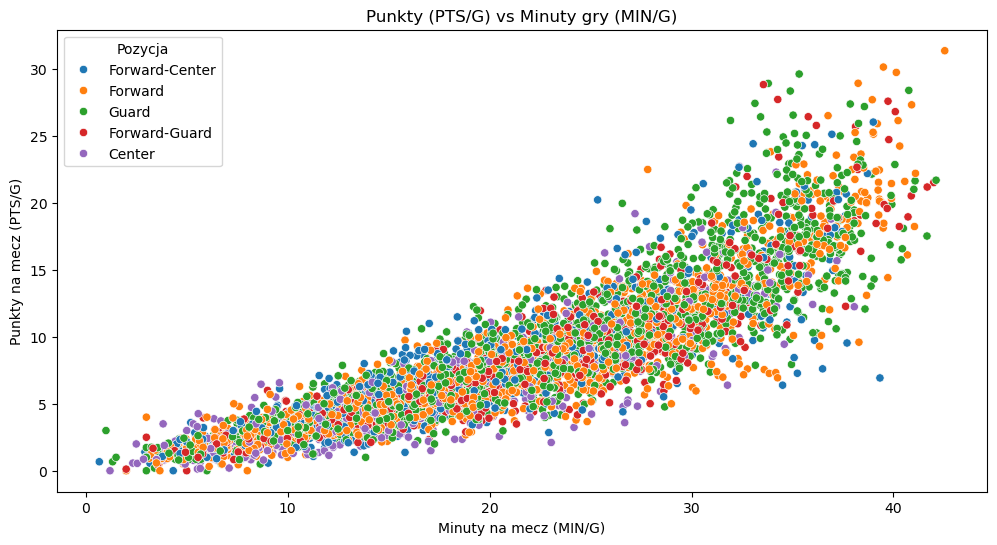

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='MIN/G', y='PTS/G', hue='POSITION')
plt.title('Punkty (PTS/G) vs Minuty gry (MIN/G)')
plt.xlabel('Minuty na mecz (MIN/G)')
plt.ylabel('Punkty na mecz (PTS/G)')
plt.legend(title='Pozycja')
plt.show()


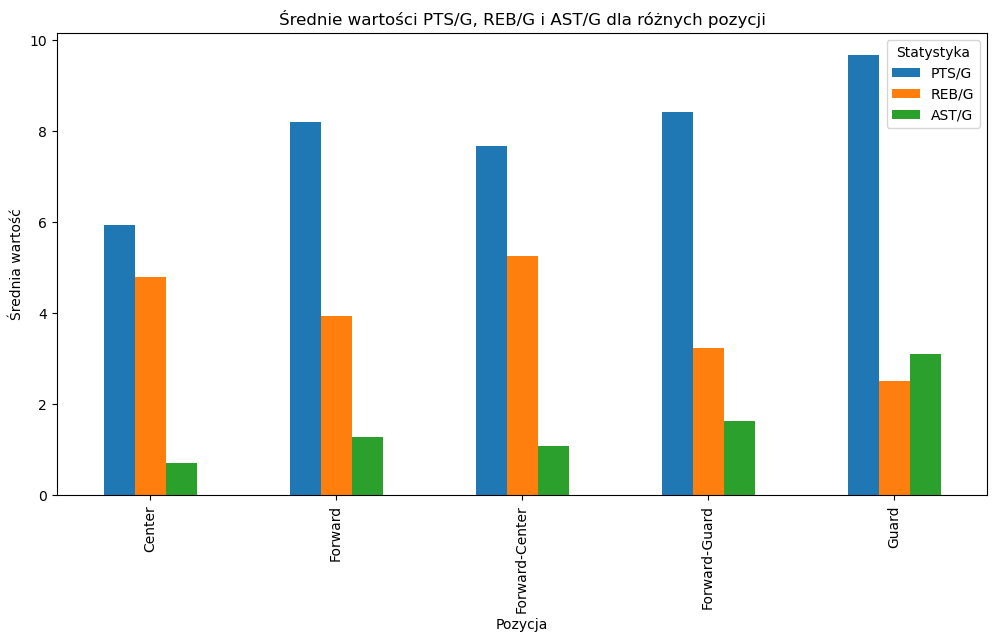

In [20]:
mean_values = data.groupby('POSITION')[['PTS/G', 'REB/G', 'AST/G']].mean().reset_index()

mean_values.plot(x='POSITION', kind='bar', figsize=(12, 6))
plt.title('Średnie wartości PTS/G, REB/G i AST/G dla różnych pozycji')
plt.xlabel('Pozycja')
plt.ylabel('Średnia wartość')
plt.legend(title='Statystyka')
plt.show()


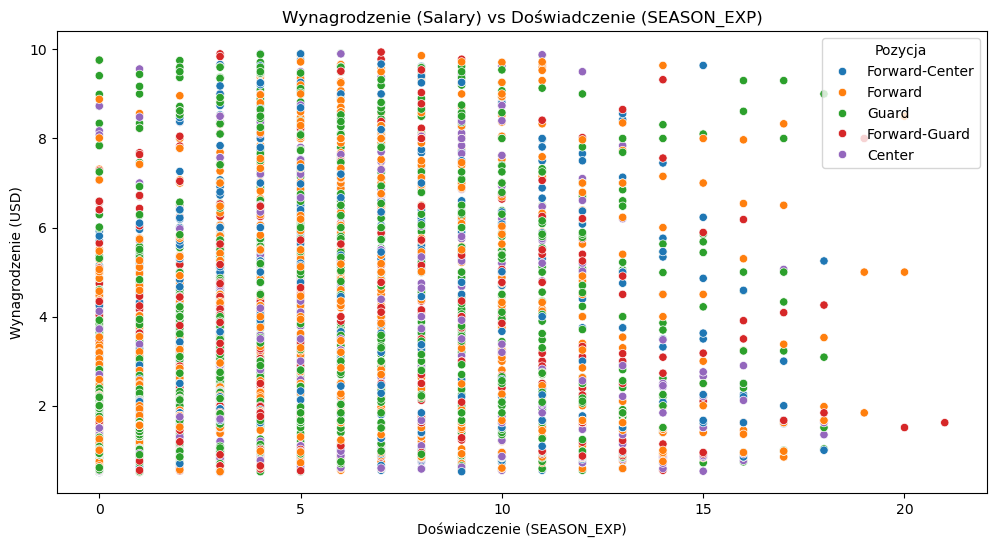

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='SEASON_EXP', y='Salary', hue='POSITION')
plt.title('Wynagrodzenie (Salary) vs Doświadczenie (SEASON_EXP)')
plt.xlabel('Doświadczenie (SEASON_EXP)')
plt.ylabel('Wynagrodzenie (USD)')
plt.legend(title='Pozycja')
plt.show()


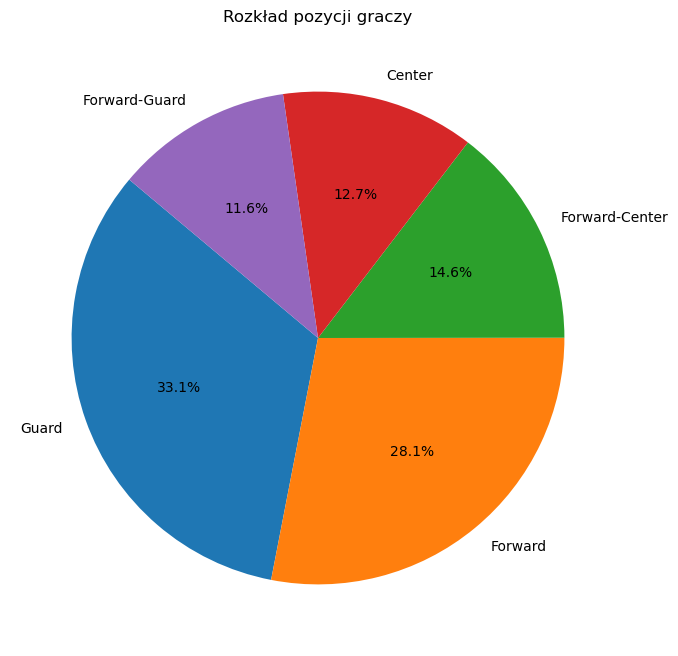

In [22]:
position_counts = data['POSITION'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Rozkład pozycji graczy')
plt.show()


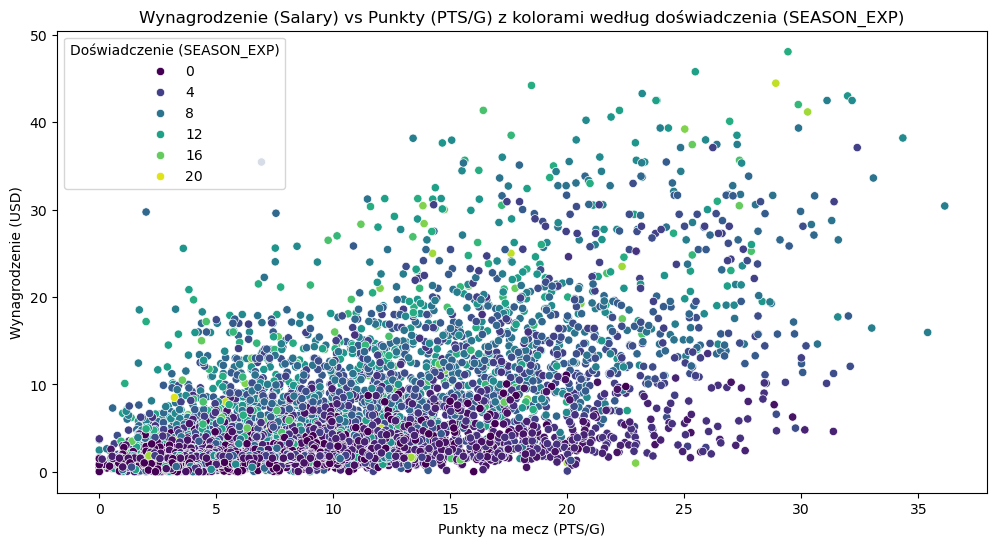

In [226]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='PTS/G', y='Salary', hue='SEASON_EXP', palette='viridis')
plt.title('Wynagrodzenie (Salary) vs Punkty (PTS/G) z kolorami według doświadczenia (SEASON_EXP)')

plt.xlabel('Punkty na mecz (PTS/G)')
plt.ylabel('Wynagrodzenie (USD)')
plt.legend(title='Doświadczenie (SEASON_EXP)')
plt.show()


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_90300/3206376847.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_counts, x='TEAM_ABBREVIATION_y', y='Count', palette='viridis')


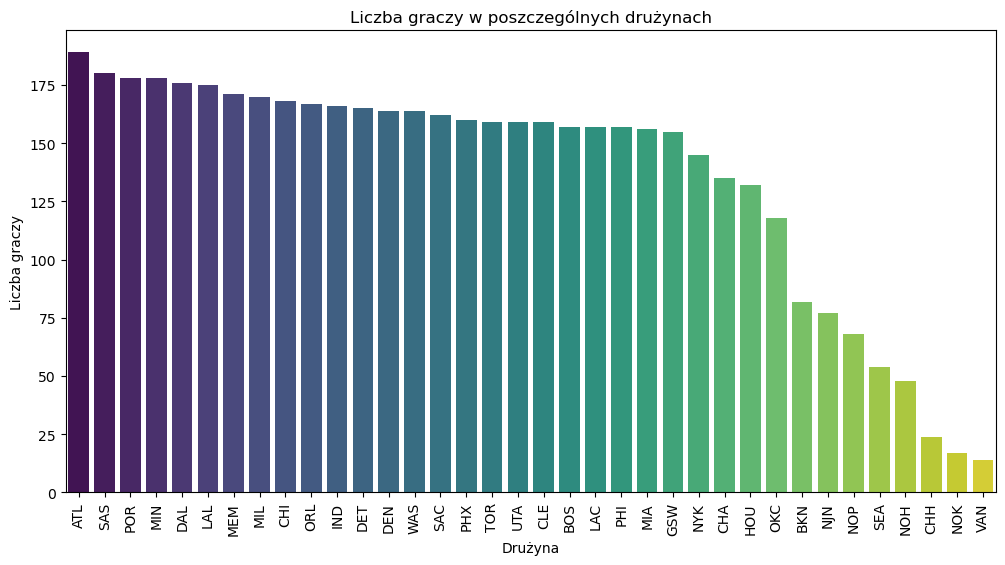

In [23]:
team_counts = data['TEAM_ABBREVIATION_y'].value_counts().reset_index()
team_counts.columns = ['TEAM_ABBREVIATION_y', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=team_counts, x='TEAM_ABBREVIATION_y', y='Count', palette='viridis')
plt.title('Liczba graczy w poszczególnych drużynach')
plt.xlabel('Drużyna')
plt.ylabel('Liczba graczy')
plt.xticks(rotation=90)
plt.show()


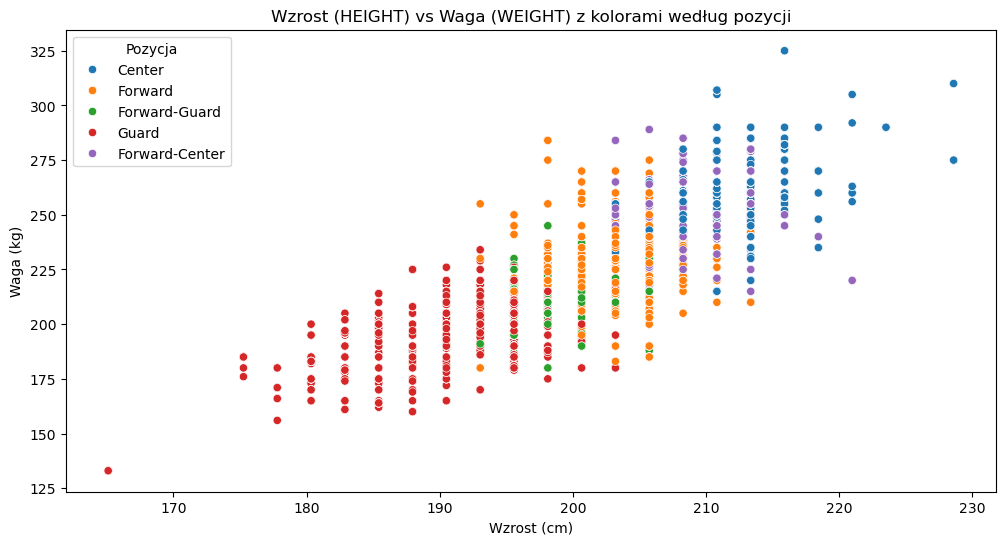

In [231]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='HEIGHT', y='WEIGHT', hue='POSITION')
plt.title('Wzrost (HEIGHT) vs Waga (WEIGHT) z kolorami według pozycji')
plt.xlabel('Wzrost (cm)')
plt.ylabel('Waga (kg)')
plt.legend(title='Pozycja')
plt.show()


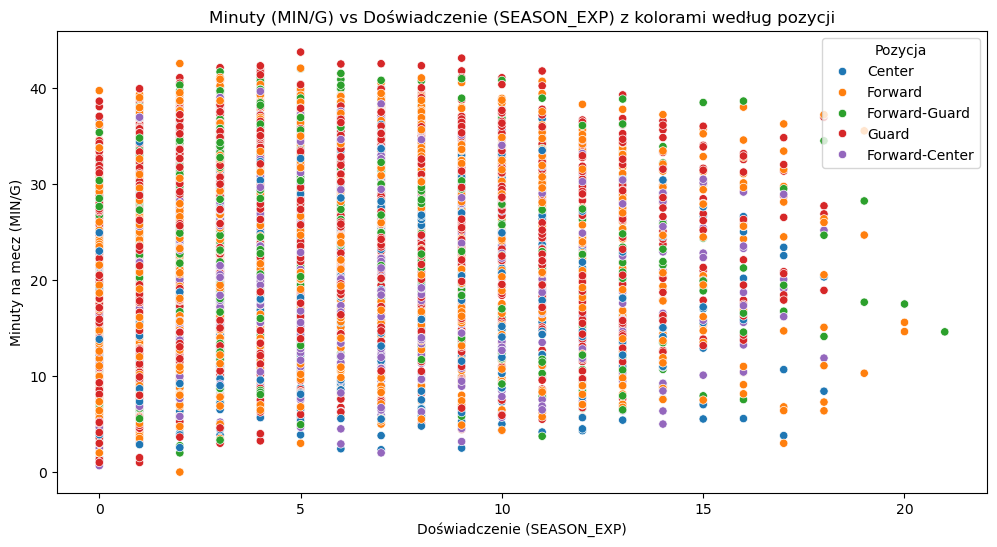

In [232]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='SEASON_EXP', y='MIN/G', hue='POSITION')
plt.title('Minuty (MIN/G) vs Doświadczenie (SEASON_EXP) z kolorami według pozycji')
plt.xlabel('Doświadczenie (SEASON_EXP)')
plt.ylabel('Minuty na mecz (MIN/G)')
plt.legend(title='Pozycja')
plt.show()


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_32097/5300490.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_blk_per_position, x='POSITION', y='BLK/G', palette='viridis')


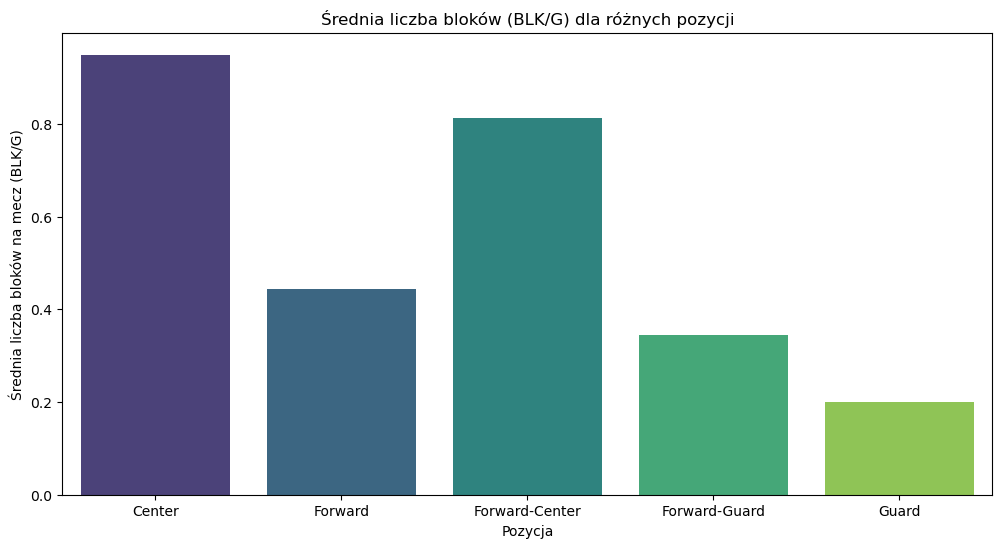

In [233]:
mean_blk_per_position = data.groupby('POSITION')['BLK/G'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=mean_blk_per_position, x='POSITION', y='BLK/G', palette='viridis')
plt.title('Średnia liczba bloków (BLK/G) dla różnych pozycji')
plt.xlabel('Pozycja')
plt.ylabel('Średnia liczba bloków na mecz (BLK/G)')
plt.show()
